# <span style='color:orange'> Machine Learning Course Project <span>

## <span style='color:green'> Training an Auto-Encoder <span>

**Description**: The notebook trains a CNN based autoencoder architecture in an unsupervised condition using data from BRATS 2017. The idea is to learn compact representation of data which can be used as features to predict Overall Survival values for each patient<br>
**Team:** Unlearners

In [1]:
import dataloader as dl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = '/home/asa224/Desktop/students_less_asa224/BRATS2017/MICCAI_BraTS17_Data_Training/HGG/'
images = dl.loadData(data_dir, loadFromDump=False, loadStandardized=False, saveDump=False, verbose=1)

[WARNING] The loader DOES NOT STANDARDIZE DATA, NEITHER IT WRITES STANDARDIZED DATA TO DISK
It can only load standardized data from disk..


Loading images...
Currently on patient 1


/rcg/software/Linux/Ubuntu/16.04/amd64/LANG/PYTHON/2.7.13-SYSTEM/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Currently on patient 2
Currently on patient 3
Currently on patient 4
Currently on patient 5
Currently on patient 6
Currently on patient 7
Currently on patient 8
Currently on patient 9
Currently on patient 10
Currently on patient 11
Currently on patient 12
Currently on patient 13
Currently on patient 14
Currently on patient 15
Currently on patient 16
Currently on patient 17
Currently on patient 18
Currently on patient 19
Currently on patient 20
Currently on patient 21
Currently on patient 22
Currently on patient 23
Currently on patient 24
Currently on patient 25
Currently on patient 26
Currently on patient 27
Currently on patient 28
Currently on patient 29
Currently on patient 30
Currently on patient 31
Currently on patient 32
Currently on patient 33
Currently on patient 34
Currently on patient 35
Currently on patient 36
Currently on patient 37
Currently on patient 38
Currently on patient 39
Currently on patient 40
Currently on patient 41
Currently on patient 42
Currently on patient 43


In [3]:
images = dl.standardize(images)

Calculating mean value..
Calculating standard deviation..
Starting standardization process..
Data standardized!
Done!


## Reshape the training matrix

**A Neural Network requires data to be in a specific shape. Currently we have the following shape: (210, 4, 120, 120, 155). We would like to reshape it in such a way that all images come together, ie. concatenate all images together and lose the information about individual patients, hence the shape should be: (210*155, 4, 120, 120) -> (32550, 120, 120, 4). To do this, we first need to swap the sequence axis and num_slices axis, and then perform reshaping**

We have to be extra careful here, as swapping and reshaping nd-arrays can lead to undesirable results. 

In [4]:
images.shape

(210, 4, 120, 120, 155)

In [5]:
images_rs = np.swapaxes(images, 1, 4)

In [6]:
images_rs.shape

(210, 155, 120, 120, 4)

In [7]:
images_rs = images_rs.reshape(-1, images_rs.shape[2], images_rs.shape[3], images_rs.shape[4])

In [8]:
images_rs.shape

(32550, 120, 120, 4)

**To determine whether shape changing was successful, we visualize the data**

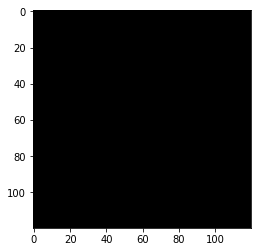

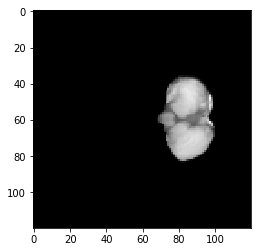

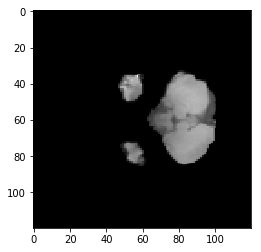

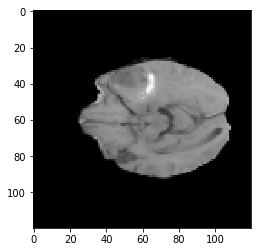

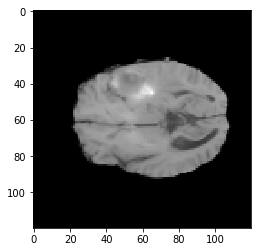

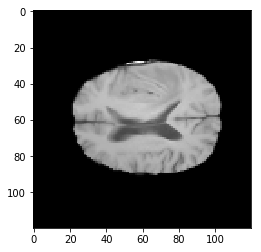

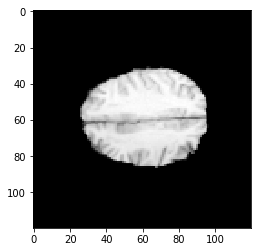

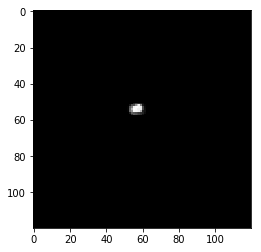

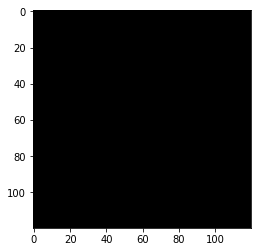

In [9]:
for i in range(0, 155, 10):
    plt.imshow(images_rs[i, :, :, 1], cmap='gray')
    plt.show()

** Shape changing was successfull and it behaved in a way that was required and expected.**

## Define network architecture

In [10]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [29]:
input_img = Input(shape=(images_rs.shape[1], images_rs.shape[2], images_rs.shape[3]))

'''
==============================================================================
Encoder
==============================================================================
'''

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv_e_1_1')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv_e_1_2')(x)
x = MaxPooling2D((2, 2), padding='same', name='Pool_e_1')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv_e_2_1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv_e_2_2')(x)
x = MaxPooling2D((2, 2), padding='same', name='Pool_e_2')(x)

# x = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv_e_3')(x)
# x = MaxPooling2D((2, 2), padding='same', name='Pool_e_3')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv_e_4_1')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv_e_4_2')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='feature')(x)

'''
==============================================================================
Decoder
==============================================================================
'''

x = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv_d_1_1')(encoded)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv_d_1_2')(x)
x = UpSampling2D((2, 2), name='Up_d_1')(x)

# x = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv_d_2')(encoded)
# x = UpSampling2D((2, 2), name='Up_d_2')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv_d_3_1')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv_d_3_2')(x)
x = UpSampling2D((2, 2), name='Up_d_3')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv_d_4_1')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv_d_4_2')(x)
x = UpSampling2D((2, 2), name='Up_d_4')(x)

decoded = Conv2D(4, (3, 3), activation='linear', padding='same', name='output')(x)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)

In [30]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120, 120, 4)       0         
_________________________________________________________________
Conv_e_1_1 (Conv2D)          (None, 120, 120, 64)      2368      
_________________________________________________________________
Conv_e_1_2 (Conv2D)          (None, 120, 120, 64)      36928     
_________________________________________________________________
Pool_e_1 (MaxPooling2D)      (None, 60, 60, 64)        0         
_________________________________________________________________
Conv_e_2_1 (Conv2D)          (None, 60, 60, 32)        18464     
_________________________________________________________________
Conv_e_2_2 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
Pool_e_2 (MaxPooling2D)      (None, 30, 30, 32)        0         
__________

In [31]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 120, 120, 4)       0         
_________________________________________________________________
Conv_e_1_1 (Conv2D)          (None, 120, 120, 64)      2368      
_________________________________________________________________
Conv_e_1_2 (Conv2D)          (None, 120, 120, 64)      36928     
_________________________________________________________________
Pool_e_1 (MaxPooling2D)      (None, 60, 60, 64)        0         
_________________________________________________________________
Conv_e_2_1 (Conv2D)          (None, 60, 60, 32)        18464     
_________________________________________________________________
Conv_e_2_2 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
Pool_e_2 (MaxPooling2D)      (None, 30, 30, 32)        0         
__________

## Split training and testing data

In [14]:
from sklearn import model_selection

X_train, X_test = model_selection.train_test_split(images_rs, test_size=0.02, random_state=42)

In [15]:
print('Shape of training data: {}'.format(X_train.shape))
print('Shape of testing data: {}'.format(X_test.shape))

Shape of training data: (31899, 120, 120, 4)
Shape of testing data: (651, 120, 120, 4)


In [38]:
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')

In [39]:
history = autoencoder.fit(x=X_train, y=X_train, 
                batch_size=200, 
                epochs=30, verbose=1, 
                callbacks=None, validation_split=0.0, 
                validation_data=[X_test, X_test], shuffle=True, 
                class_weight=None, sample_weight=None, 
                initial_epoch=0, steps_per_epoch=None, 
                validation_steps=None)

Train on 31899 samples, validate on 651 samples
Epoch 1/30
31899/31899 [==============================] - 150s - loss: 0.1080 - val_loss: 0.0918
Epoch 2/30
31899/31899 [==============================] - 138s - loss: 0.0977 - val_loss: 0.0777
Epoch 3/30
31899/31899 [==============================] - 127s - loss: 0.0801 - val_loss: 0.0675
Epoch 4/30
31899/31899 [==============================] - 126s - loss: 0.0694 - val_loss: 0.0602
Epoch 5/30
31899/31899 [==============================] - 126s - loss: 0.0634 - val_loss: 0.0549
Epoch 6/30
31899/31899 [==============================] - 128s - loss: 0.0592 - val_loss: 0.0508
Epoch 7/30
31899/31899 [==============================] - 128s - loss: 0.0547 - val_loss: 0.0498
Epoch 8/30
31899/31899 [==============================] - 127s - loss: 0.0541 - val_loss: 0.0494
Epoch 9/30
31899/31899 [==============================] - 129s - loss: 0.0519 - val_loss: 0.0519
Epoch 10/30
31899/31899 [==============================] - 128s - loss: 0.0518 

In [40]:
autoencoder.save('AE_30.h5')

## Visualize how our autoencoder is doing..

In [34]:
print('Decoding images...')
decoded_imgs = autoencoder.predict(X_test)
print('Decoding done!')

Decoding images...
Decoding done!


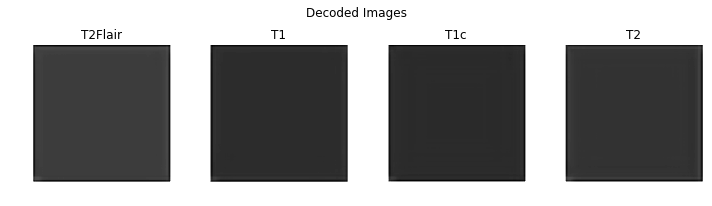

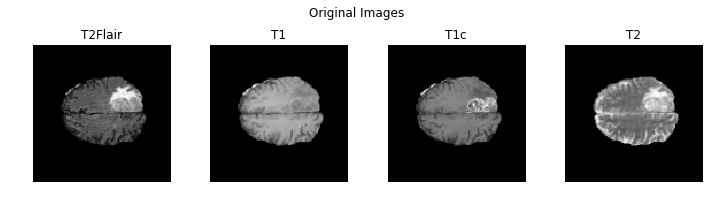

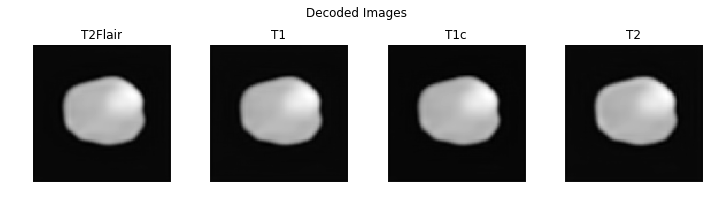

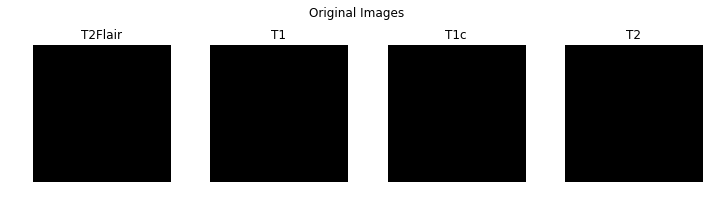

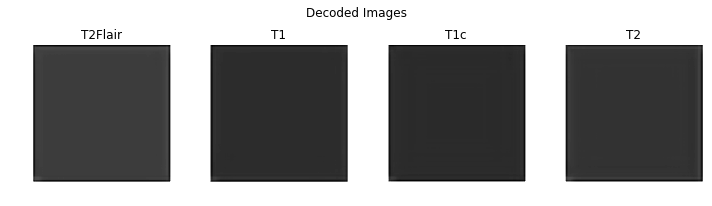

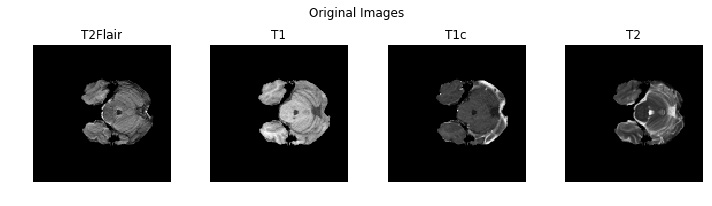

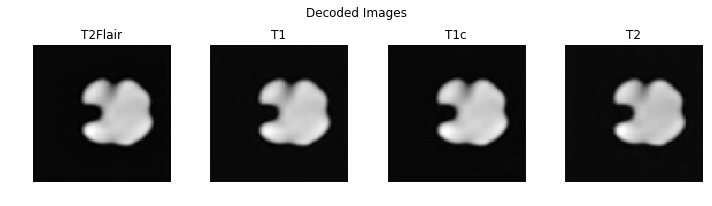

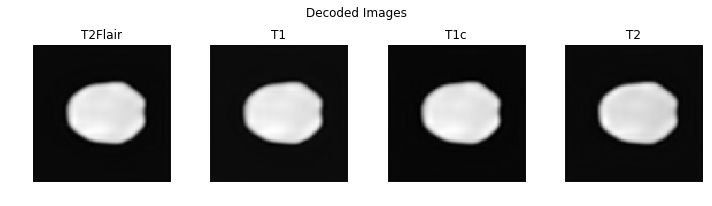

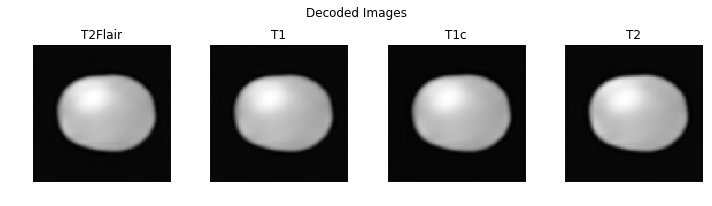

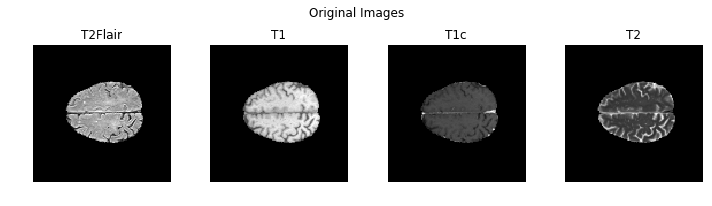

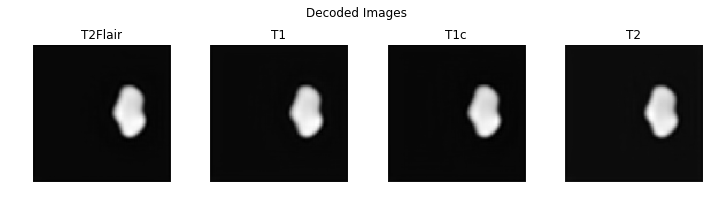

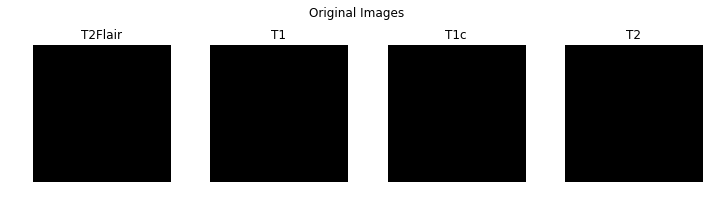

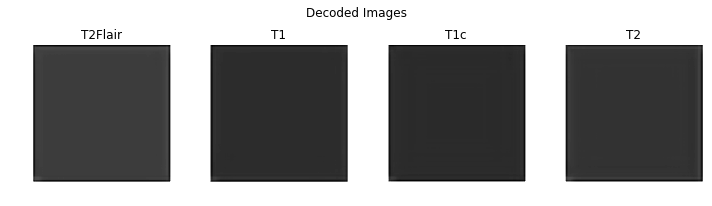

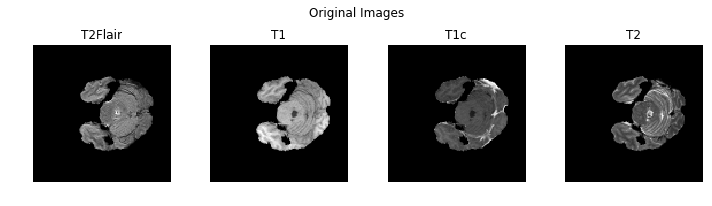

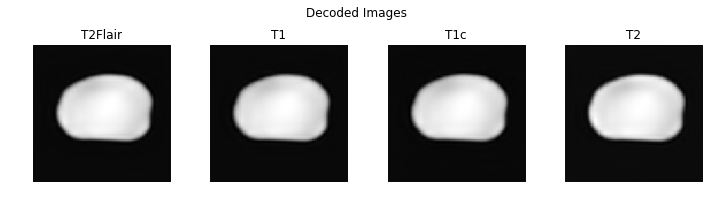

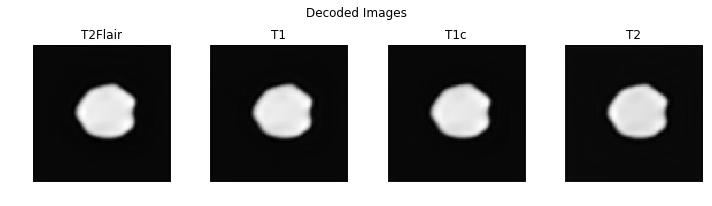

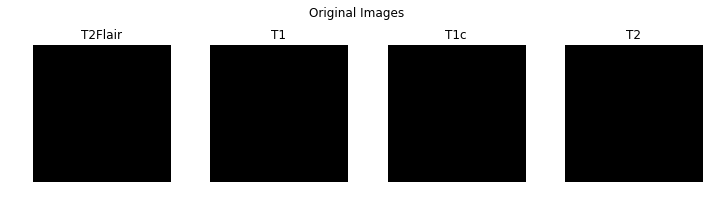

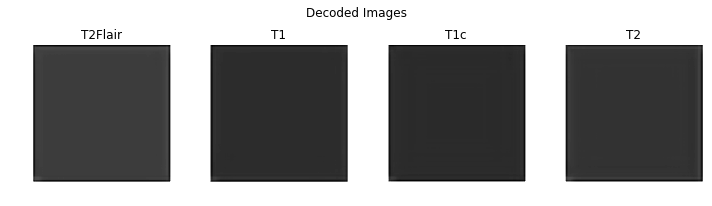

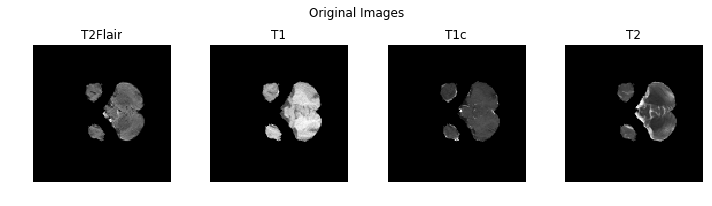

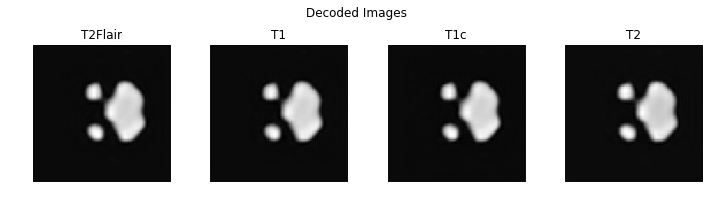

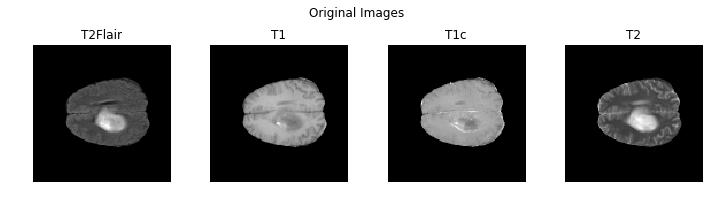

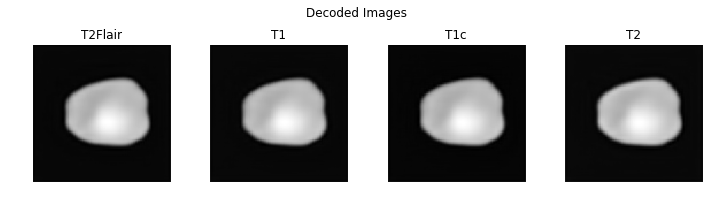

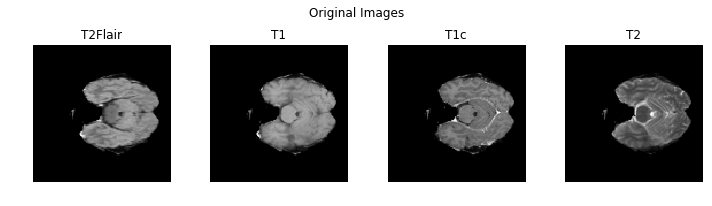

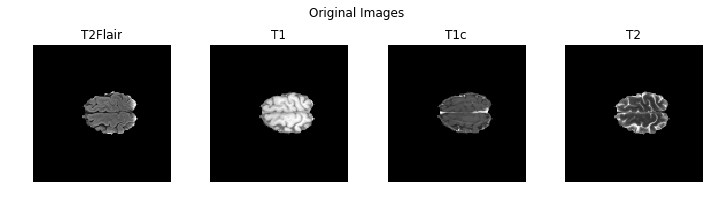

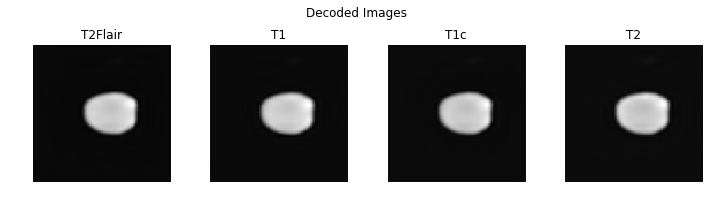

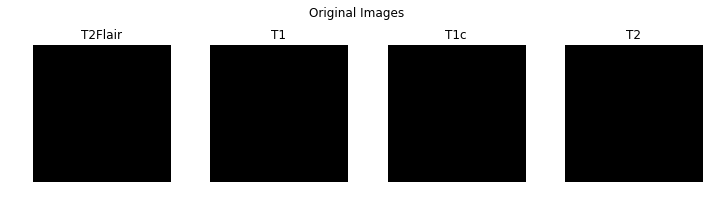

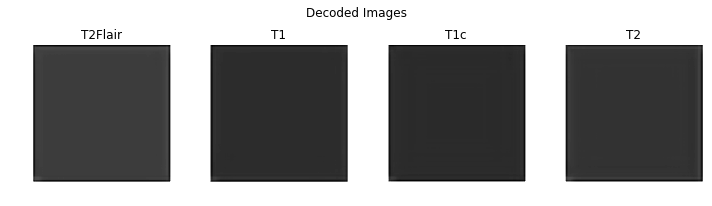

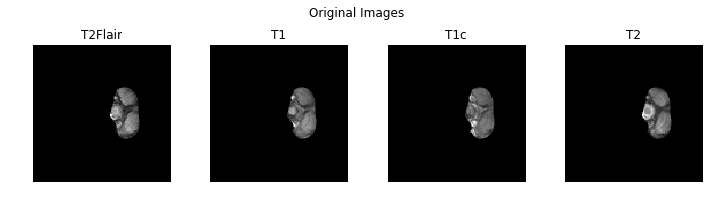

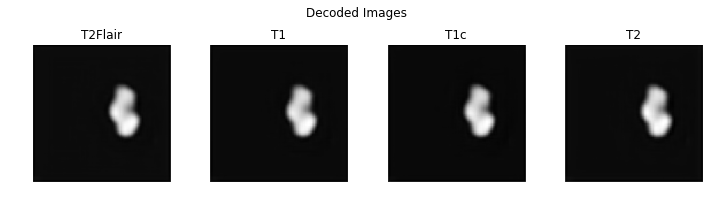

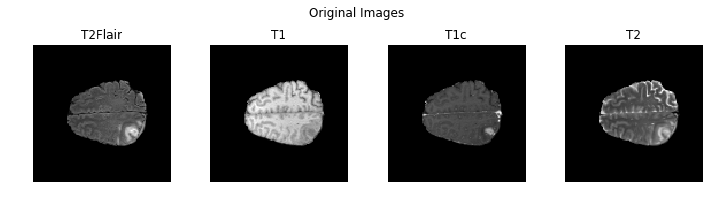

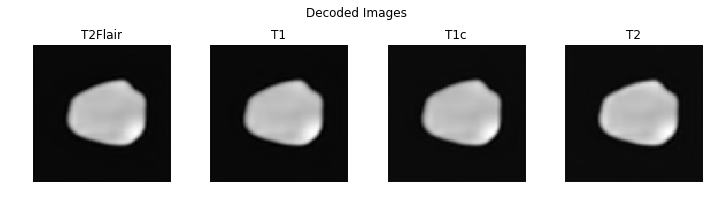

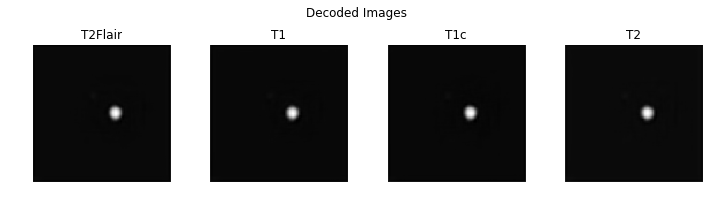

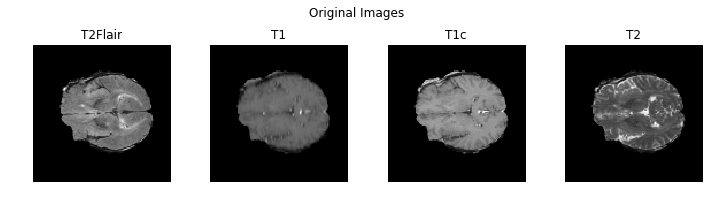

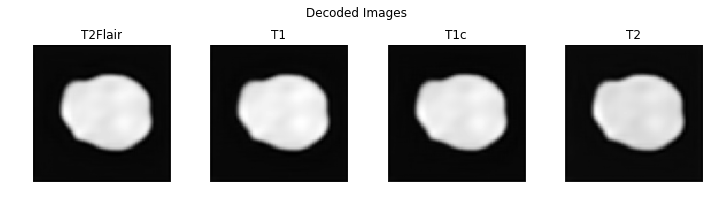

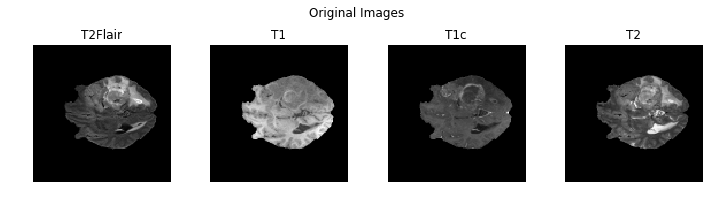

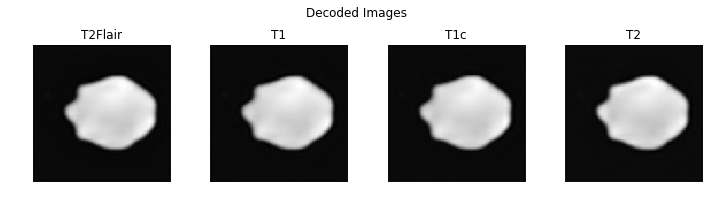

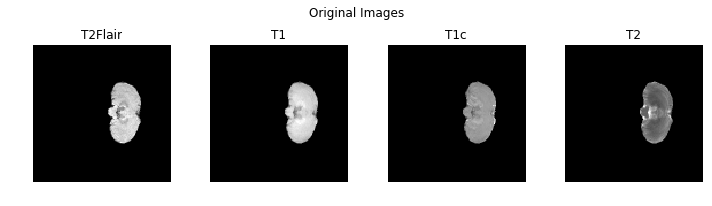

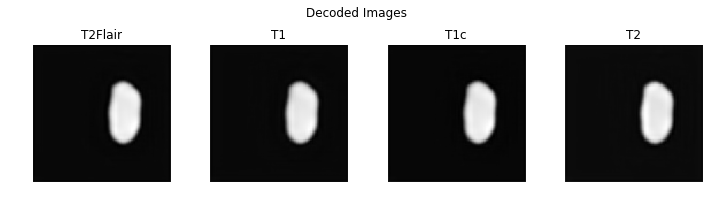

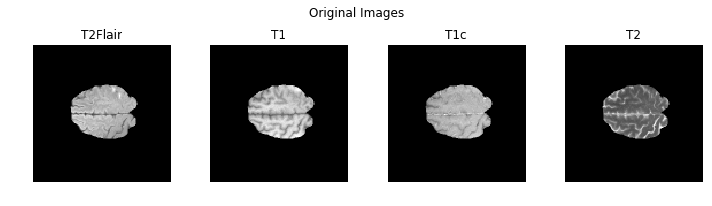

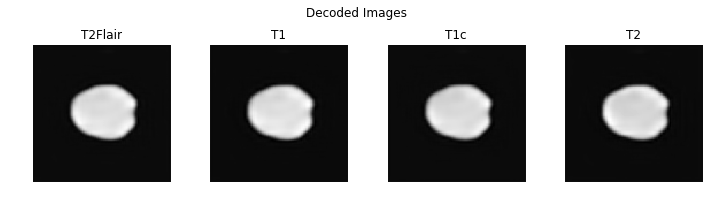

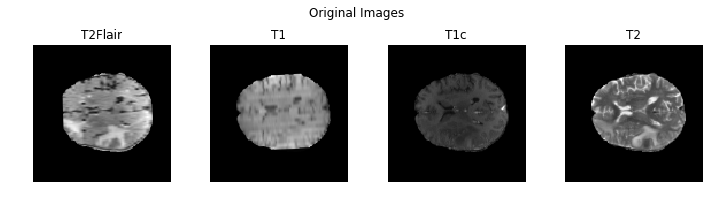

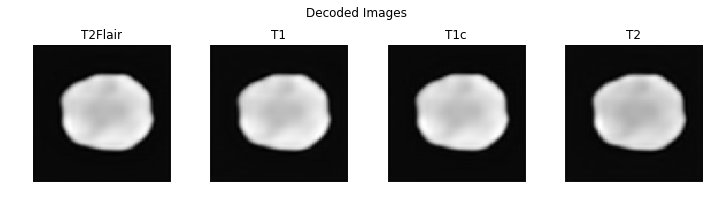

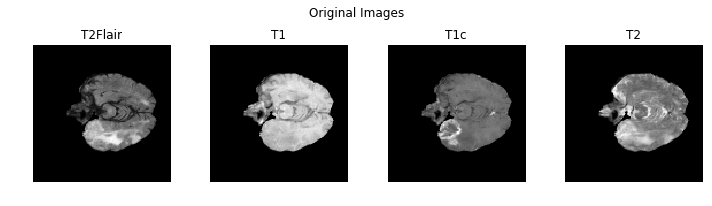

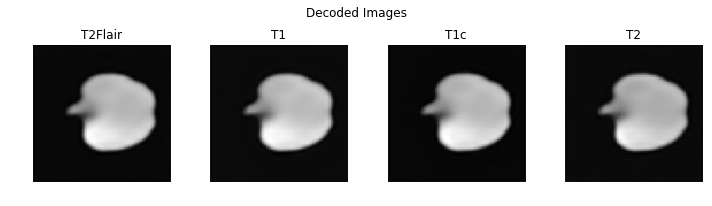

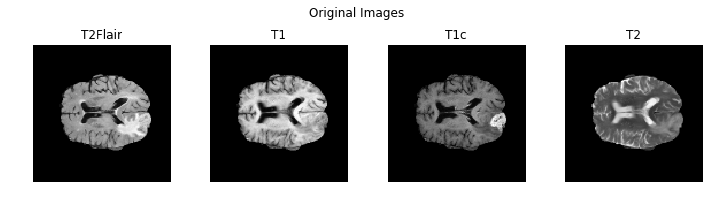

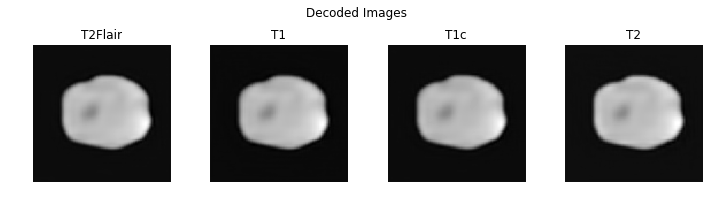

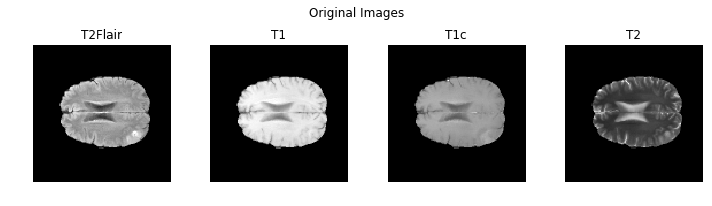

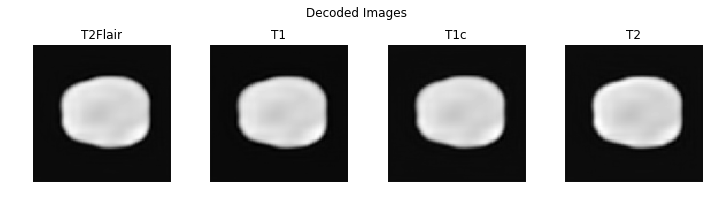

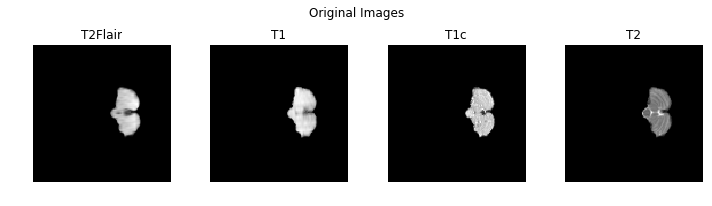

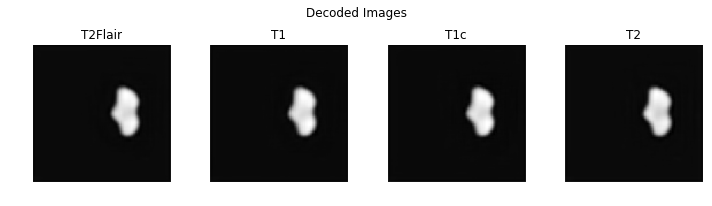

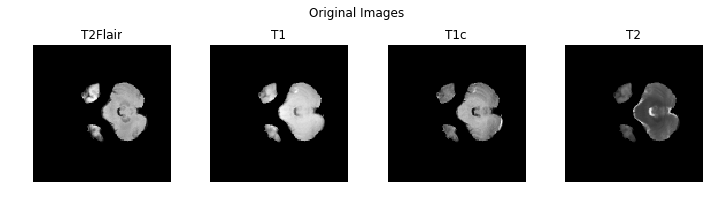

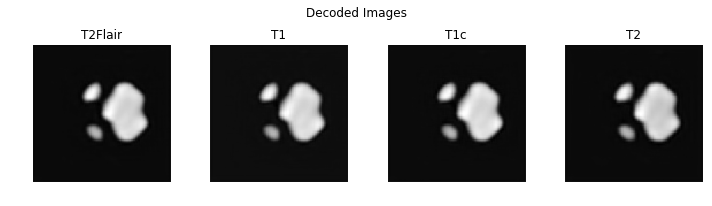

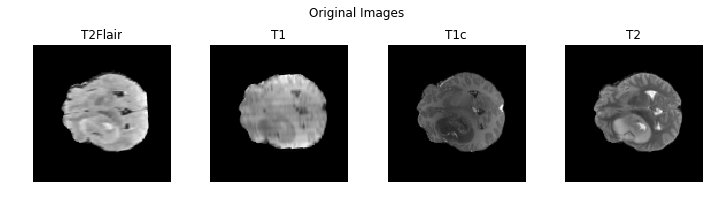

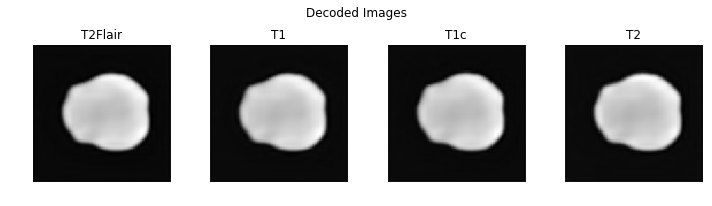

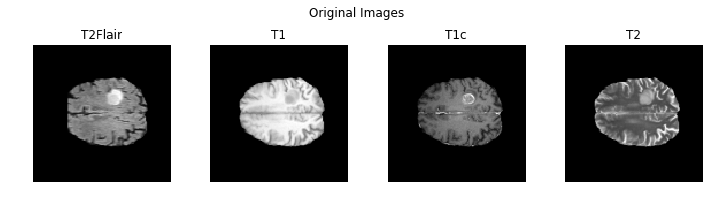

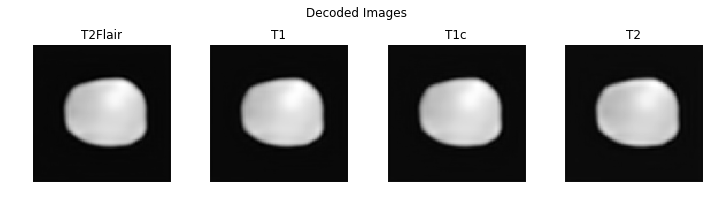

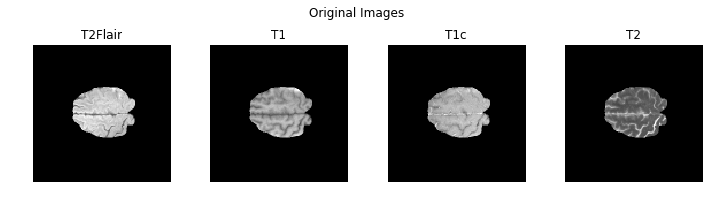

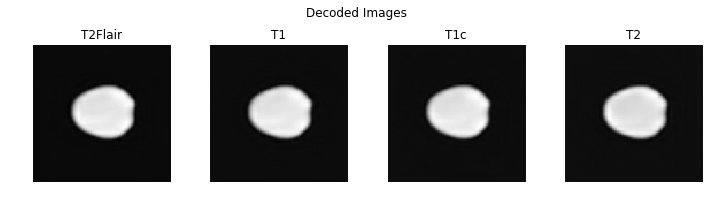

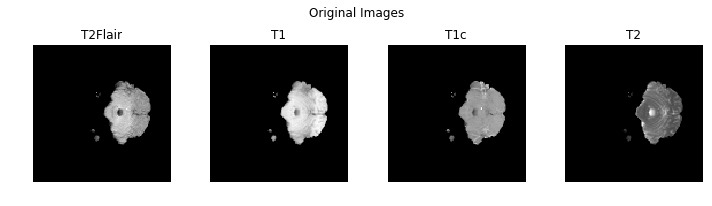

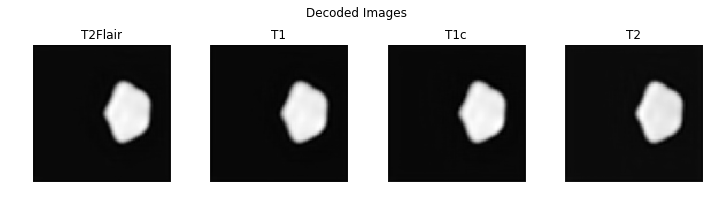

In [35]:
# (32550, 120, 120, 4)
n = 400
for i in range(0, n, 10):
    # display original
    print('='*100)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
    ax1.set_title('T2Flair')
    ax1.imshow(X_test[i,:,:,0], cmap='gray')
    ax2.set_title('T1')
    ax2.imshow(X_test[i,:,:,1], cmap='gray')
    ax3.set_title('T1c')
    ax3.imshow(X_test[i,:,:,2], cmap='gray')
    ax4.set_title('T2')
    ax4.imshow(X_test[i,:,:,3], cmap='gray')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    f.tight_layout()
    f.subplots_adjust(top=1.65)
    plt.suptitle('Original Images')
    plt.show()

    # display reconstruction
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))
    ax1.set_title('T2Flair')
    ax1.imshow(decoded_imgs[i,:,:,0], cmap='gray')
    ax2.set_title('T1')
    ax2.imshow(decoded_imgs[i,:,:,1], cmap='gray')
    ax3.set_title('T1c')
    ax3.imshow(decoded_imgs[i,:,:,2], cmap='gray')
    ax4.set_title('T2')
    ax4.imshow(decoded_imgs[i,:,:,3], cmap='gray')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    f.tight_layout()
    f.subplots_adjust(top=1.65)
    plt.suptitle('Decoded Images')
    plt.show()
    print('='*100)
    print('\n')